## Hackathon 3 : Sentiment Classification

<b>Problem Statement</b>
<p>Twitter has now become a useful way to build one's business as it helps in giving the brand a voice and a personality. The platform is also a quick, easy and inexpensive way to gain valuable insight from the desired audience. Identifying the sentiments about the product/brand can help the business take better actions.</p>

You have with you evaluated tweets about multiple brands. The evaluators(random audience) were asked if the tweet expressed positive, negative, or no emotion towards a product/brand and labelled accordingly.

<b>Dataset Description</b> 
<p>This dataset contains around 7k tweet text with the sentiment label.

The file train.csv has 3 columns

tweet_id - Unique id for tweets. tweet - Tweet about the brand/product sentiment - 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell </p>

<b>Evaluation Metric</b> 
<p> We will be using ‘weighted’ F1-measure as the evaluation metric for this competition. For more information on the F1-metric refer to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html  </p>

<b>Submission format</b> 
<p> Submission file should have two columns, one for tweet_id and sencond for sentiment [0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell]. A sample submission file has also been attached for reference. </p>

## Start of Notebook

#### Why are we doing this
- To Classify the Tweets into positive , neutral , negative, Cant tell
- To Identify sentiments of product/brand

#### Stakeholders:
- Customer of Withwicky 
- DataScience head or Project Manager of WithWicky

In [176]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from html.parser import HTMLParser
from textblob import TextBlob
import string
from spellchecker import SpellChecker


from sklearn.feature_extraction.text import TfidfVectorizer
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from autocorrect import Speller
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#Stemmmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer

#Lemmatization
from nltk.stem import WordNetLemmatizer


import plotly.offline as pyo
from plotly import graph_objs as go
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [177]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\ProgramData\Anaconda3\share\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [178]:
analyzer = SentimentIntensityAnalyzer()

In [179]:
def vader_add_negative(text):
    result = analyzer.polarity_scores(text)
    return result['neg']

In [180]:
def vader_add_neutral(text):
    result = analyzer.polarity_scores(text)
    return result['neu']

In [181]:
def vader_add_positive(text):
    result = analyzer.polarity_scores(text)
    return result['pos']

In [182]:
def vader_add_compound(text):
    result = analyzer.polarity_scores(text)
    return result['compound']

#### Import DataSet

In [183]:
traindf = pd.read_csv("train.csv")
#testdf = pd.read_csv("test.csv")

In [184]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

## EDA

#### Checking Train DataSet

In [185]:
traindf.head()

tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

In [186]:
temp = traindf.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)

In [187]:
temp

sentiment  tweet
1          1   4310
2          2   2382
0          0    456
3          3    125

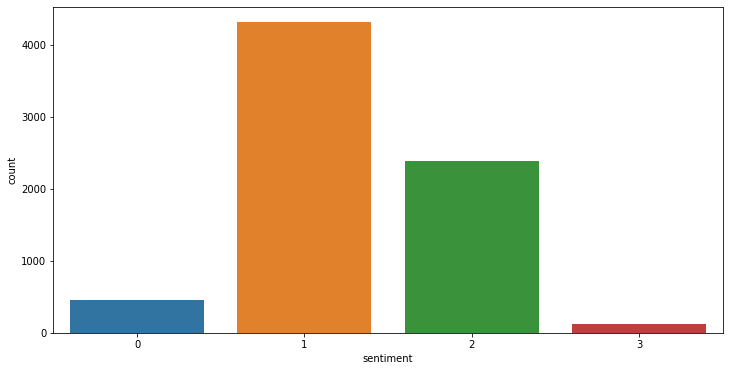

In [188]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=traindf)

In [189]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))

fig.show()

In [190]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

In [191]:
traindf.dtypes

tweet_id      int64
tweet        object
sentiment     int64
dtype: object

In [192]:
traindf.head()


tweet_id                                              tweet  sentiment
0      1701  #sxswnui #sxsw #apple defining language of tou...          1
1      1851  Learning ab Google doodles! All doodles should...          1
2      2689  one of the most in-your-face ex. of stealing t...          2
3      4525  This iPhone #SXSW app would b pretty awesome i...          0
4      3604  Line outside the Apple store in Austin waiting...          1

In [193]:
traindf.info

<bound method DataFrame.info of       tweet_id                                              tweet  sentiment
0         1701  #sxswnui #sxsw #apple defining language of tou...          1
1         1851  Learning ab Google doodles! All doodles should...          1
2         2689  one of the most in-your-face ex. of stealing t...          2
3         4525  This iPhone #SXSW app would b pretty awesome i...          0
4         3604  Line outside the Apple store in Austin waiting...          1
...        ...                                                ...        ...
7269      3343  @mention Google plze Tammi.  I'm in middle of ...          1
7270      5334  RT @mention ÷¼ Are you all set? ÷_ {link} ÷...          1
7271      5378  RT @mention Aha! Found proof of lactation room...          1
7272      2173  We just launched our iPad app at #SXSW! Get al...          1
7273      3162  The next fin serv battle is vs Apple, GOOG, Mo...          1

[7274 rows x 3 columns]>

## Stop Words Removal

stopwords.words('english')


In [194]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Data Cleaning

In [195]:
# Function for converting emoticons into word
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [196]:
convert_emoticons("Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw")

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw Happy face or smiley #SXSW #cbatsxsw'

In [197]:
traindf.tweet[220]

'Awwww yeah!!! RT @mention Congrats to @mention on winning the last @mention #iPad case for her boyfriend aw :) #SXSW #cbatsxsw'

In [198]:
def dataCleaning(df,stemming = False, lemmatization=False):
    html_parser = HTMLParser()
    
    # convert column type to string
    df['tweet'] = df['tweet'].astype(str)
    
    
    # to lower case
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    #removing @mention
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[mention]+)',' ',x))
    
    #removing @handles , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(@[A-Za-z0-9]+)',' ',x))
    
     #removing Http links , since trending tweets are on Hashtags
    df['tweet']= df['tweet'].apply(lambda x: re.sub('http\S+',' ',x))
    
    #converting emoticon
    df['tweet']= df['tweet'].apply(lambda x: convert_emoticons(x))
    
    #handling apostrophe
    df['tweet']= df['tweet'].apply(lambda x: re.sub("’", "'",x))
       
    # remove numbers
    df['tweet']= df['tweet'].apply(lambda x: re.sub(r'\d+', ' ', x))
    

    # remove punctuations and convert characters to lower case
    df['tweet'] = df['tweet'].apply(lambda x: "".join([char.lower() for char in x if char not in string.punctuation]))
    
    #converting Html Encoding
    
    df['tweet']= df['tweet'].apply(lambda x: html_parser.unescape(x))
    
    #removing #HashTags 
    #df['tweet']= df['tweet'].apply(lambda x: re.sub('(#[A-Za-x0-9\\_\\]+)',' ',x))
    
    # #removing '#' symbol 
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(#+)',' ',x))
     
    
    #replacing double whitespace with single 
    df['tweet']= df['tweet'].apply(lambda x: re.sub(' +', ' ',x))
    
    #Removing RT
    df['tweet']= df['tweet'].apply(lambda x: re.sub('(rt)\W', ' ',x))
    
    #stopword removal  , removed NOT from STOP-WORDS
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    stop_words = all_stopwords
    traindf['tweet'] =  traindf['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    #Subjectivity
    df['subjectivity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity )
    
    #polarity
    df['polarity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity )
    
    #VADER
    df['negative'] = df['tweet'].apply(lambda x: vader_add_negative(str(x)))
    df['positive'] = df['tweet'].apply(lambda x: vader_add_positive(str(x)))
    df['neutral'] = df['tweet'].apply(lambda x: vader_add_neutral(str(x)))
    df['compound'] = df['tweet'].apply(lambda x: vader_add_compound(str(x)))
    
    if stemming:
        #st = SnowballStemmer('english')
        st = PorterStemmer()
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([st.stem(w) for w in x.split()]))
                                        
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        df['tweet'] = df['tweet'].apply(lambda x: " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in x.split()]))
    
#     #Spelling Correction
#     df['tweet']= df['tweet'].apply(lambda x: TextBlob(x).correct() )
      
    
    return df

In [199]:
traindf = dataCleaning(traindf,stemming=True,lemmatization=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



In [200]:
traindf.tweet[220]

'awwww yeah congrat win last ipad case boyfriend aw happi face smiley sxsw cbatsxsw'

In [201]:
traindf.head()

tweet_id                                              tweet  sentiment  \
0      1701  sxswnui sxsw appl defin languag touch differ d...          1   
1      1851  learn ab googl doodl doodl light funni amp inn...          1   
2      2689  one inyourfac ex steal show yr quotat sxsw app...          2   
3      4525  iphon sxsw app would b pretti awesom didnt cra...          0   
4      3604  line outsid appl store austin wait new ipad sx...          1   

   subjectivity  polarity  negative  positive  neutral  compound  
0      0.650000  0.150000     0.000     0.000    1.000    0.0000  
1      0.893750  0.381250     0.000     0.409    0.591    0.7650  
2      0.000000  0.000000     0.236     0.000    0.764   -0.5719  
3      1.000000  0.625000     0.000     0.465    0.535    0.8611  
4      0.252273  0.068182     0.000     0.000    1.000    0.0000

tfidf = TfidfVectorizer(stop_words="english")

In [202]:
traindf_filtered = traindf.drop(['tweet_id'],axis=1)

In [203]:
tfidf = TfidfVectorizer()

In [204]:
vector_tfidf = tfidf.fit_transform(traindf_filtered['tweet'])



In [205]:
X_tfidf = vector_tfidf.toarray()


In [206]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [207]:
df1 = pd.DataFrame(vector_tfidf.toarray(), columns=tfidf.get_feature_names())
print(df1)

      aapl  aaplconfus  aaron        ab  abacu  abacusconfus  abba  abc  aber  \
0      0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
1      0.0         0.0    0.0  0.287172    0.0           0.0   0.0  0.0   0.0   
2      0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
3      0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
4      0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
...    ...         ...    ...       ...    ...           ...   ...  ...   ...   
7269   0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
7270   0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
7271   0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
7272   0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   
7273   0.0         0.0    0.0  0.000000    0.0           0.0   0.0  0.0   0.0   

      abil  ...  ûïview  ûï

In [208]:
res = pd.concat([traindf_filtered, df1], axis=1)


In [209]:
res =res.drop(['tweet'],axis=1)

In [210]:
res.head()

sentiment  subjectivity  polarity  negative  positive  neutral  compound  \
0          1      0.650000  0.150000     0.000     0.000    1.000    0.0000   
1          1      0.893750  0.381250     0.000     0.409    0.591    0.7650   
2          2      0.000000  0.000000     0.236     0.000    0.764   -0.5719   
3          0      1.000000  0.625000     0.000     0.465    0.535    0.8611   
4          1      0.252273  0.068182     0.000     0.000    1.000    0.0000   

   aapl  aaplconfus  aaron  ...  ûïview  ûïwin   ûò  ûòand   ûó  ûócan  \
0   0.0         0.0    0.0  ...     0.0    0.0  0.0    0.0  0.0    0.0   
1   0.0         0.0    0.0  ...     0.0    0.0  0.0    0.0  0.0    0.0   
2   0.0         0.0    0.0  ...     0.0    0.0  0.0    0.0  0.0    0.0   
3   0.0         0.0    0.0  ...     0.0    0.0  0.0    0.0  0.0    0.0   
4   0.0         0.0    0.0  ...     0.0    0.0  0.0    0.0  0.0    0.0   

   ûójust  ûólewi  ûómi  ûóth  
0     0.0     0.0   0.0   0.0  
1     0.0     0.0   0.0   0.0  
2     0.0     0.0   0.0   0.0  
3     0.0     0.0   0.0   0.0  
4     0.0     0.0   0.0   0.0  

[5 rows x 7722 columns]

In [211]:
any(res['neutral']<0)

False

In [212]:
resX=res.drop(['sentiment'],axis=1)
resY = res.sentiment

In [213]:
print("df",X_tfidf.shape)

df (7274, 7716)


In [214]:
traindf['sentiment']

0       1
1       1
2       2
3       0
4       1
       ..
7269    1
7270    1
7271    1
7272    1
7273    1
Name: sentiment, Length: 7274, dtype: int64

# RESEARCH WORK -- DONT TOUCH"

### Common for both below

In [215]:
# Predictors
x = resX

# Target
y = resY

#TestDF
testdf = pd.read_csv("test.csv")
testdf = dataCleaning(testdf,stemming=True,lemmatization=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning:

The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.



## For simple

In [216]:
def run_model(predictors,target,test_df, model,model_name):
    print("inside "+model_name)
    predictors.shape
    target.shape
    print(":::")
    x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=42)
    
    #SMOTE
    sm = SMOTE()
    x_train_new, y_train_new = sm.fit_sample(x_train,y_train)
    
    model.fit(x_train_new, y_train_new)
    y_pred = model.predict(x_test)
    print('Classification Report:')
    print(classification_report(y_test,y_pred))
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))

    print("testdf, ",test_df.shape)
    
    test_id_col = test_df['tweet_id']
    print("test_id_col ",test_id_col.shape)
    
    print("Dropping Id column")
    test_df_drop_id = test_df.drop(['tweet_id'],axis=1)
    print("test_df_drop_id ",test_df_drop_id.shape)
    
    #Transform Test DataSet using TFiDF
    testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])
    
    testdf1 = pd.DataFrame(testdf_tfidf.toarray(), columns=tfidf.get_feature_names())
    testres = pd.concat([test_df_drop_id, testdf1], axis=1)
    testres =testres.drop(['tweet'],axis=1)
    
    #Predicting TestValues
    print('Predicting TestValues')
    predict = model.predict(testres)
  
    print(predict.shape)
    print(testres.shape)

    print('Adding Test prediction to Column')
    #Adding Test prediction to Column
    test_df_drop_id['sentiment']= model.predict(testres)
    
    print('Concat both column to Pandas')
    #Concat both column to Pandas
    submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
    print('Creating CSV')
    #Creating CSV
    submissions_nb.to_csv('submissions_simple_'+model_name+'.csv', index=False) 
    
    print("successfully completed "+model_name)

'Multinomial NaiveBais':MultinomialNB,

In [217]:
xgbSoftmax=XGBClassifier(objective='multi:softmax')
#SimplexgbClassifier = XGBClassifier()
#SimplexgbRF = XGBRFClassifier()
#hyperxgb = XGBRFClassifier()

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.

#models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier,
#         'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,'SimplexgbClassifier': XGBClassifier,
#          'XGBSoftMax' :xgbSoftmax,'SimplexgbRF':XGBRFClassifier    }

models = {'Logistic Regression':LogisticRegression,'Linear SVM': SGDClassifier,
         'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,'SimplexgbClassifier': XGBClassifier,
          'XGBSoftMax' :xgbSoftmax,'SimplexgbRF':XGBRFClassifier    }
    

for i in models.items():
    # run model
    model = i[1]()
    model_name = i[0]
    print("x: ",x.shape)
    print(" y -senti shape: ",y.shape)
    run_model(x,y,testdf, model,model_name) # train and returns AUC test score
    print('===='*20)

x:  (7274, 7721)
 y -senti shape:  (7274,)
inside Logistic Regression
:::


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.56      0.40       121
           1       0.75      0.70      0.72      1304
           2       0.57      0.57      0.57       719
           3       0.03      0.03      0.03        39

    accuracy                           0.63      2183
   macro avg       0.42      0.46      0.43      2183
weighted avg       0.65      0.63      0.64      2183

F1 weighted score: 0.6398701079861374
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Logistic Regression
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside Linear SVM
:::
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.54      0.40       121
           1       0.75      0.70      0.72      1304
      

KeyboardInterrupt: 

### PArams for GRIDCV

In [221]:
logistic_param = dict(
                    penalty= ['l1', 'l2','elasticnet'],
    #penalty= ['elasticnet'], 
                  C= [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 300, 500] 
                #  solver=['liblinear', 'saga','sag','lbfgs']
                #  solver=['saga']
                  )

In [222]:
logistic_param

{'penalty': ['l1', 'l2', 'elasticnet'],
 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 300, 500]}

In [223]:
MultiNBparams = dict(
                #alpha= [0.5,1, 1.5],
               fit_prior = [True, False] 
            )

In [224]:
SGDparams = dict(
                  penalty= ['l1', 'l2','elasticnet'] 
                )

In [225]:
DecisionTreeClassifierparams = dict(
                               criterion = ['gini','entropy']
                               splitter= ['best','random']
                                )

SyntaxError: invalid syntax (<ipython-input-225-0c766cc1a426>, line 3)

In [227]:
# Number of trees in random forest
n_estimators = [100,150,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,25]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]


# Create the random grid
RandomForestClassifierparam = {'n_estimators': n_estimators,
               'max_features': max_features
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf
                              }

In [228]:
BernoulliNBparam = {
                    'fit_prior':[True,False]
}

In [229]:
ExtraTreesClassifierParam = {
    'criterion':['gini','entropy']
    
}

In [230]:
XGBRFClassifierparam = {'n_estimators': [100,150,200],
              # 'learning_rate': [0.001,0.01,0.5,1],
               }

ParamsGrid = [ logistic_param ,MultiNBparams,SGDparams,DecisionTreeClassifierparams,RandomForestClassifierparam ,BernoulliNBparam,ExtraTreesClassifierParam,XGBRFClassifierparam  ]

In [231]:
ParamsGrid = [ logistic_param ,SGDparams,DecisionTreeClassifierparams,RandomForestClassifierparam ,BernoulliNBparam,ExtraTreesClassifierParam,XGBRFClassifierparam  ]

## For GridCV

In [235]:
def run_model_gridcv(predictors,target,test_df, model,model_name,params):
    print("inside "+model_name)
    predictors.shape
    target.shape
    print(":::")
    
    
    x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size=0.3,random_state=42)
    
    #SMOTE
    sm = SMOTE()
    x_train_new, y_train_new = sm.fit_sample(x_train,y_train)
    
    #grid
    grid = GridSearchCV(estimator=model,param_grid = params, cv = 5, n_jobs=2, verbose=9)
    
    grid.fit(x_train_new, y_train_new)
    y_pred = grid.predict(x_test)
    print('Classification Report:')
    print(classification_report(y_test,y_pred))
    #false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print('F1 weighted score:', f1_score(y_test, y_pred, average='weighted'))
    
    print("testdf, ",test_df.shape)
    
    test_id_col = test_df['tweet_id']
    print("test_id_col ",test_id_col.shape)
    
    print("Dropping Id column")
    test_df_drop_id = test_df.drop(['tweet_id'],axis=1)
    print("test_df_drop_id ",test_df_drop_id.shape)
    
    #Transform Test DataSet using TFiDF
    testdf_tfidf = tfidf.transform(test_df_drop_id['tweet'])
    
    testdf1 = pd.DataFrame(testdf_tfidf.toarray(), columns=tfidf.get_feature_names())
    testres = pd.concat([test_df_drop_id, testdf1], axis=1)
    testres =testres.drop(['tweet'],axis=1)
    
    
    #Predicting TestValues
    print('Predicting TestValues')
    predict = grid.predict(testres)
  
    print(predict.shape)
    print(testres.shape)

    print('Adding Test prediction to Column')
    #Adding Test prediction to Column
    test_df_drop_id['sentiment']= grid.predict(testres)
    
    print('Concat both column to Pandas')
    #Concat both column to Pandas
    submissions_nb = pd.concat([test_id_col, test_df_drop_id['sentiment']], axis=1) 
    
    print('Creating CSV')
    #Creating CSV
    submissions_nb.to_csv('submissions_GridCV_'+model_name+'.csv', index=False) 
    
    print("successfully completed "+model_name)

In [236]:


# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier}

# modelsForGrid = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier,
#          'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,
#          'BernoulliNB':BernoulliNB , 'ExtraTreesClassifier' :ExtraTreesClassifier , 'XGBRFClassifier':XGBRFClassifier  }

modelsForGrid = {'Logistic Regression':LogisticRegression,'Linear SVM': SGDClassifier,
         'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,
         'BernoulliNB':BernoulliNB , 'ExtraTreesClassifier' :ExtraTreesClassifier , 'XGBRFClassifier':XGBRFClassifier  }

p=0;
for i in modelsForGrid.items():
    # run model
    
    model = i[1]()
    model_name = i[0]
#     print("X_Tfidf: ",X_tfidf.shape)
#     print("senti shape: ",traindf['sentiment'].shape)
    print("x: ",x.shape)
    print(" y -senti shape: ",y.shape)
    run_model_gridcv(x,y,testdf, model,model_name,params= ParamsGrid[p]) # train and returns AUC test score
    p=p+1;
    print('===='*20)

x:  (7274, 7721)
 y -senti shape:  (7274,)
inside Logistic Regression
:::
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   23.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   55.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 11.5min
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed: 13.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       121
           1       0.73      0.74      0.73      1304
           2       0.55      0.56      0.55       719
           3       0.06      0.03      0.04        39

    accuracy                           0.64      2183
   macro avg       0.43      0.42      0.42      2183
weighted avg       0.64      0.64      0.64      2183

F1 weighted score: 0.6411326472020048
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Logistic Regression
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside Linear SVM
:::
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed: 12.5min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.52      0.42       121
           1       0.75      0.67      0.71      1304
           2       0.54      0.61      0.57       719
           3       0.03      0.03      0.03        39

    accuracy                           0.63      2183
   macro avg       0.42      0.46      0.43      2183
weighted avg       0.64      0.63      0.63      2183

F1 weighted score: 0.6344352679706986
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Linear SVM
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside Decision Tree
:::
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   39.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.5min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.35      0.30       121
           1       0.71      0.72      0.72      1304
           2       0.53      0.49      0.51       719
           3       0.06      0.03      0.04        39

    accuracy                           0.61      2183
   macro avg       0.39      0.40      0.39      2183
weighted avg       0.61      0.61      0.61      2183

F1 weighted score: 0.612389745407965
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed Decision Tree
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside RandomForestClassifier
:::
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 11.8min
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 24.5min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.30      0.37       121
           1       0.71      0.81      0.76      1304
           2       0.60      0.52      0.56       719
           3       0.25      0.03      0.05        39

    accuracy                           0.67      2183
   macro avg       0.51      0.41      0.43      2183
weighted avg       0.65      0.67      0.66      2183

F1 weighted score: 0.6566305395537925
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed RandomForestClassifier
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside BernoulliNB
:::
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   31.2s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   59.3s finished


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.35      0.36       121
           1       0.71      0.74      0.73      1304
           2       0.56      0.53      0.54       719
           3       0.05      0.03      0.03        39

    accuracy                           0.64      2183
   macro avg       0.42      0.41      0.42      2183
weighted avg       0.63      0.64      0.63      2183

F1 weighted score: 0.6349918423791358
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed BernoulliNB
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside ExtraTreesClassifier
:::
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 10.0min finished


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.26      0.35       121
           1       0.71      0.83      0.77      1304
           2       0.62      0.52      0.56       719
           3       0.14      0.03      0.04        39

    accuracy                           0.68      2183
   macro avg       0.50      0.41      0.43      2183
weighted avg       0.66      0.68      0.66      2183

F1 weighted score: 0.6640803951390282
testdf,  (1819, 8)
test_id_col  (1819,)
Dropping Id column
test_df_drop_id  (1819, 7)
Predicting TestValues
(1819,)
(1819, 7721)
Adding Test prediction to Column
Concat both column to Pandas
Creating CSV
successfully completed ExtraTreesClassifier
x:  (7274, 7721)
 y -senti shape:  (7274,)
inside XGBRFClassifier
:::


ValueError: Parameter grid for parameter (verbosity) needs to be a list or numpy array, but got (<class 'int'>). Single values need to be wrapped in a list with one element.

# RESEARCH -2  (left over model)

### XGBClassifier

## Hyper Parameter

In [84]:
#models

#models
xgbSoftmax=XGBClassifier(objective='multi:softmax')
SimplexgbClassifier = XGBClassifier()
SimplexgbRF = XGBRFClassifier()
hyperxgb = XGBRFClassifier()


# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier}
modelsExtra = { 'XGBSoftmax':xgbSoftmax, 'SimpleXGBClassifier':SimplexgbClassifier, 'SimpleXGBRF': SimplexgbRF, 'HyperxgbRF': hyperxgb  }

In [238]:
XGBRFClassifierparam = {'n_estimators': [100,150,200]
              # 'learning_rate': [0.001,0.01,0.5,1],
               } 

In [239]:
ParamsGridExtra = [XGBRFClassifierparam]

In [ ]:


# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
# models = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier}

# modelsForGrid = {'Logistic Regression':LogisticRegression,'Multinomial NaiveBais':MultinomialNB,'Linear SVM': SGDClassifier,
#          'Decision Tree': DecisionTreeClassifier, 'RandomForestClassifier': RandomForestClassifier,
#          'BernoulliNB':BernoulliNB , 'ExtraTreesClassifier' :ExtraTreesClassifier , 'XGBRFClassifier':XGBRFClassifier  }

modelsForGrid = { 'XGBRFClassifier':XGBRFClassifier  }

p=0;
for i in modelsForGrid.items():
    # run model
    
    model = i[1]()
    model_name = i[0]
#     print("X_Tfidf: ",X_tfidf.shape)
#     print("senti shape: ",traindf['sentiment'].shape)
    print("x: ",x.shape)
    print(" y -senti shape: ",y.shape)
    run_model_gridcv(x,y,testdf, model,model_name,params= ParamsGrid[p]) # train and returns AUC test score
    p=p+1;
    print('===='*20)

x:  (7274, 7721)
 y -senti shape:  (7274,)
inside XGBRFClassifier
:::
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
